In [10]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt
from glob import glob

#url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
#urllib.request.urlretrieve(url, filename)
in_dir = glob('images/*')
print(in_dir)


['images\\dog.jpg', 'images\\family.jpg', 'images\\countryside.jpg', 'images\\me.jpg.jpeg']


### Load model

In [4]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load('intel-isl/MiDaS', model_type, trust_repo= True)

Using cache found in C:\Users\agraumnitz/.cache\torch\hub\intel-isl_MiDaS_master


### Move model to GPU if availlable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
midas.to(device)
midas.eval()

### Load Transfomrs for resize and normalize

In [6]:
midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms', trust_repo = True)

if model_type == 'DPT_Large' or model_type == 'DPT_Hybrid':
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\agraumnitz/.cache\torch\hub\intel-isl_MiDaS_master


### Load image and apply transforms

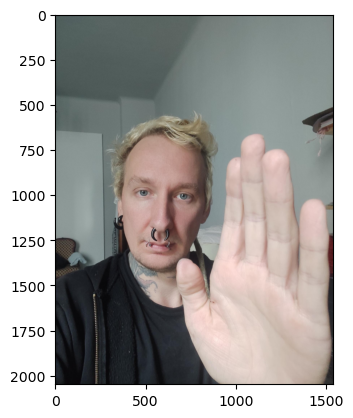

In [19]:
img = cv2.imread(in_dir[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

input_batch = transform(img).to(device)

### Predict and resize to original resolution

In [20]:
with torch.inference_mode():
    prediction = midas(input_batch)
    
    prediction = torch.nn.functional.interpolate( # Skaliert die Tiefendarstellung auf die Größe des Ursprünglichen Bildes
        prediction.unsqueeze(1), # Batchdimension hinzugefügt, wichtig für das Midas Modell -> 1 Batch, 1 Bild
        size = img.shape[:2], # enthält die ursprüngliche Größe des Bildes
        mode = 'bicubic', # rechenintensiv, liefert gute Qualität
        align_corners = False, # True = Ecken des Bildes werden bei Skalierung erhalten, False = Kanten werden erhalten
    ).squeeze() # Batch dimension wird wieder entfernt
    
output = prediction.cpu().numpy()

### Show result

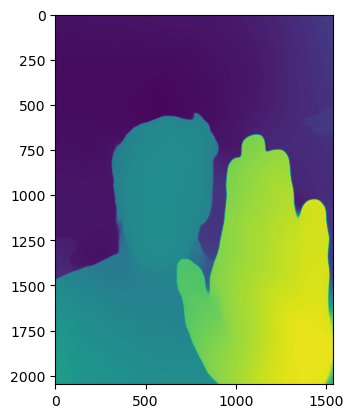

In [21]:
plt.imshow(output)
plt.show()